In [17]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib import dates
from datetime import datetime

from linearmodels import PooledOLS
from linearmodels import PanelOLS
from linearmodels import RandomEffects
import statsmodels.api as sm
from statsmodels.stats.diagnostic import het_breuschpagan
from statsmodels.stats.stattools import durbin_watson

from scipy import stats

%matplotlib inline

### Background

Countdown is an Australian-owned New Zealand full-service supermarket chain and subsidiary

When it comes to the retail industry, there is no denying that sales are the backbone of their business model. It is the driving force that propels their profits, making it the most important metric to track. By analyzing sales data, businesses can gain valuable insights into their operations and make informed decisions on how to improve and optimize their business model.

Our dataset provides a unique opportunity to explore the trends and seasonality of Countdown Sales, and determine whether macroeconomic conditions have any effect on this metric. To do this, we will be utilizing Econometric Panel Regression techniques, specifically Fixed Effect and Random Effect models. Through this analysis, we hope to shed light on the factors that contribute to Countdown Sales and provide valuable insights into the overall health of the industry.



#####  Data Description
This dataset contain 8 available feature:

Store, Date, Weekly_Sales, Temperature, Holiday_Flag, Fuel_Price, CPI (Consumer Price Index), Unemployment

#####  Holiday Dates 
Super Bowl: 12-Feb-10, 11-Feb-11, 10-Feb-12, 8-Feb-13
Labour Day: 10-Sep-10, 9-Sep-11, 7-Sep-12, 6-Sep-13
Thanksgiving: 26-Nov-10, 25-Nov-11, 23-Nov-12, 29-Nov-13
Christmas: 31-Dec-10, 30-Dec-11, 28-Dec-12, 27-Dec-13

In [18]:
df = pd.read_csv('NZ_Store_sales.csv')
df.head()

,Store,Date,Weekly_Sales,Holiday_Flag,Temperature,Fuel_Price,CPI,Unemployment
0,1,05-02-2010,1643690.90,0,42.31,2.572,211.096358,8.106
1,1,12-02-2010,1641957.44,1,38.51,2.548,211.242170,8.106
2,1,19-02-2010,1611968.17,0,39.93,2.514,211.289143,8.106
3,1,26-02-2010,1409727.59,0,46.63,2.561,211.319643,8.106
4,1,05-03-2010,1554806.68,0,46.50,2.625,211.350143,8.106


In [19]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6435 entries, 0 to 6434
Data columns (total 8 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Store         6435 non-null   int64  
 1   Date          6435 non-null   object 
 2   Weekly_Sales  6435 non-null   float64
 3   Holiday_Flag  6435 non-null   int64  
 4   Temperature   6435 non-null   float64
 5   Fuel_Price    6435 non-null   float64
 6   CPI           6435 non-null   float64
 7   Unemployment  6435 non-null   float64
dtypes: float64(5), int64(2), object(1)
memory usage: 402.3+ KB


In [20]:
df.describe()

,Store,Weekly_Sales,Holiday_Flag,Temperature,Fuel_Price,CPI,Unemployment
count,6435.000000,6.435000e+03,6435.000000,6435.000000,6435.000000,6435.000000,6435.000000
mean,23.000000,1.046965e+06,0.069930,60.663782,3.358607,171.578394,7.999151
std,12.988182,5.643666e+05,0.255049,18.444933,0.459020,39.356712,1.875885
min,1.000000,2.099862e+05,0.000000,-2.060000,2.472000,126.064000,3.879000
25%,12.000000,5.533501e+05,0.000000,47.460000,2.933000,131.735000,6.891000
50%,23.000000,9.607460e+05,0.000000,62.670000,3.445000,182.616521,7.874000
75%,34.000000,1.420159e+06,0.000000,74.940000,3.735000,212.743293,8.622000
max,45.000000,3.818686e+06,1.000000,100.140000,4.468000,227.232807,14.313000


In [21]:
years = dates.YearLocator()
months = dates.MonthLocator()
years_fmt = dates.DateFormatter('%b %Y')

df['Date'] = pd.to_datetime(df['Date'], format = '%d-%m-%Y')

#for simplicity, we use 1k unit in sales
df['Weekly_Sales'] = round(df['Weekly_Sales'] / 1000, 3)
df['CPI'] = round(df['CPI'], 2)

df2 = df.copy()

#build panel data sorting by store and date
df2 = df2.sort_values(by = 'Date')
panel = pd.pivot_table(df2, values = ['Weekly_Sales', 'Holiday_Flag', 'Temperature',
       'Fuel_Price', 'CPI', 'Unemployment'], index = ['Store', 'Date']).reset_index()
panel['Month'] = panel['Date'].dt.month
panel['Year'] = panel['Date'].dt.year

panel.head()

,Store,Date,CPI,Fuel_Price,Holiday_Flag,Temperature,Unemployment,Weekly_Sales,Month,Year
0,1,2010-02-05,211.10,2.572,0,42.31,8.106,1643.691,2,2010
1,1,2010-02-12,211.24,2.548,1,38.51,8.106,1641.957,2,2010
2,1,2010-02-19,211.29,2.514,0,39.93,8.106,1611.968,2,2010
3,1,2010-02-26,211.32,2.561,0,46.63,8.106,1409.728,2,2010
4,1,2010-03-05,211.35,2.625,0,46.50,8.106,1554.807,3,2010


In [22]:
panel.drop(['Month', 'Year', 'Store'], axis = 1).describe()

,CPI,Fuel_Price,Holiday_Flag,Temperature,Unemployment,Weekly_Sales
count,6435.000000,6435.000000,6435.000000,6435.000000,6435.000000,6435.000000
mean,171.578468,3.358607,0.069930,60.663782,7.999151,1046.964876
std,39.356697,0.459020,0.255049,18.444933,1.875885,564.366622
min,126.060000,2.472000,0.000000,-2.060000,3.879000,209.986000
25%,131.740000,2.933000,0.000000,47.460000,6.891000,553.350000
50%,182.620000,3.445000,0.000000,62.670000,7.874000,960.746000
75%,212.745000,3.735000,0.000000,74.940000,8.622000,1420.158500
max,227.230000,4.468000,1.000000,100.140000,14.313000,3818.686000


##### Time Series Analysis

Does the Dataset have a seasonal quality to it?

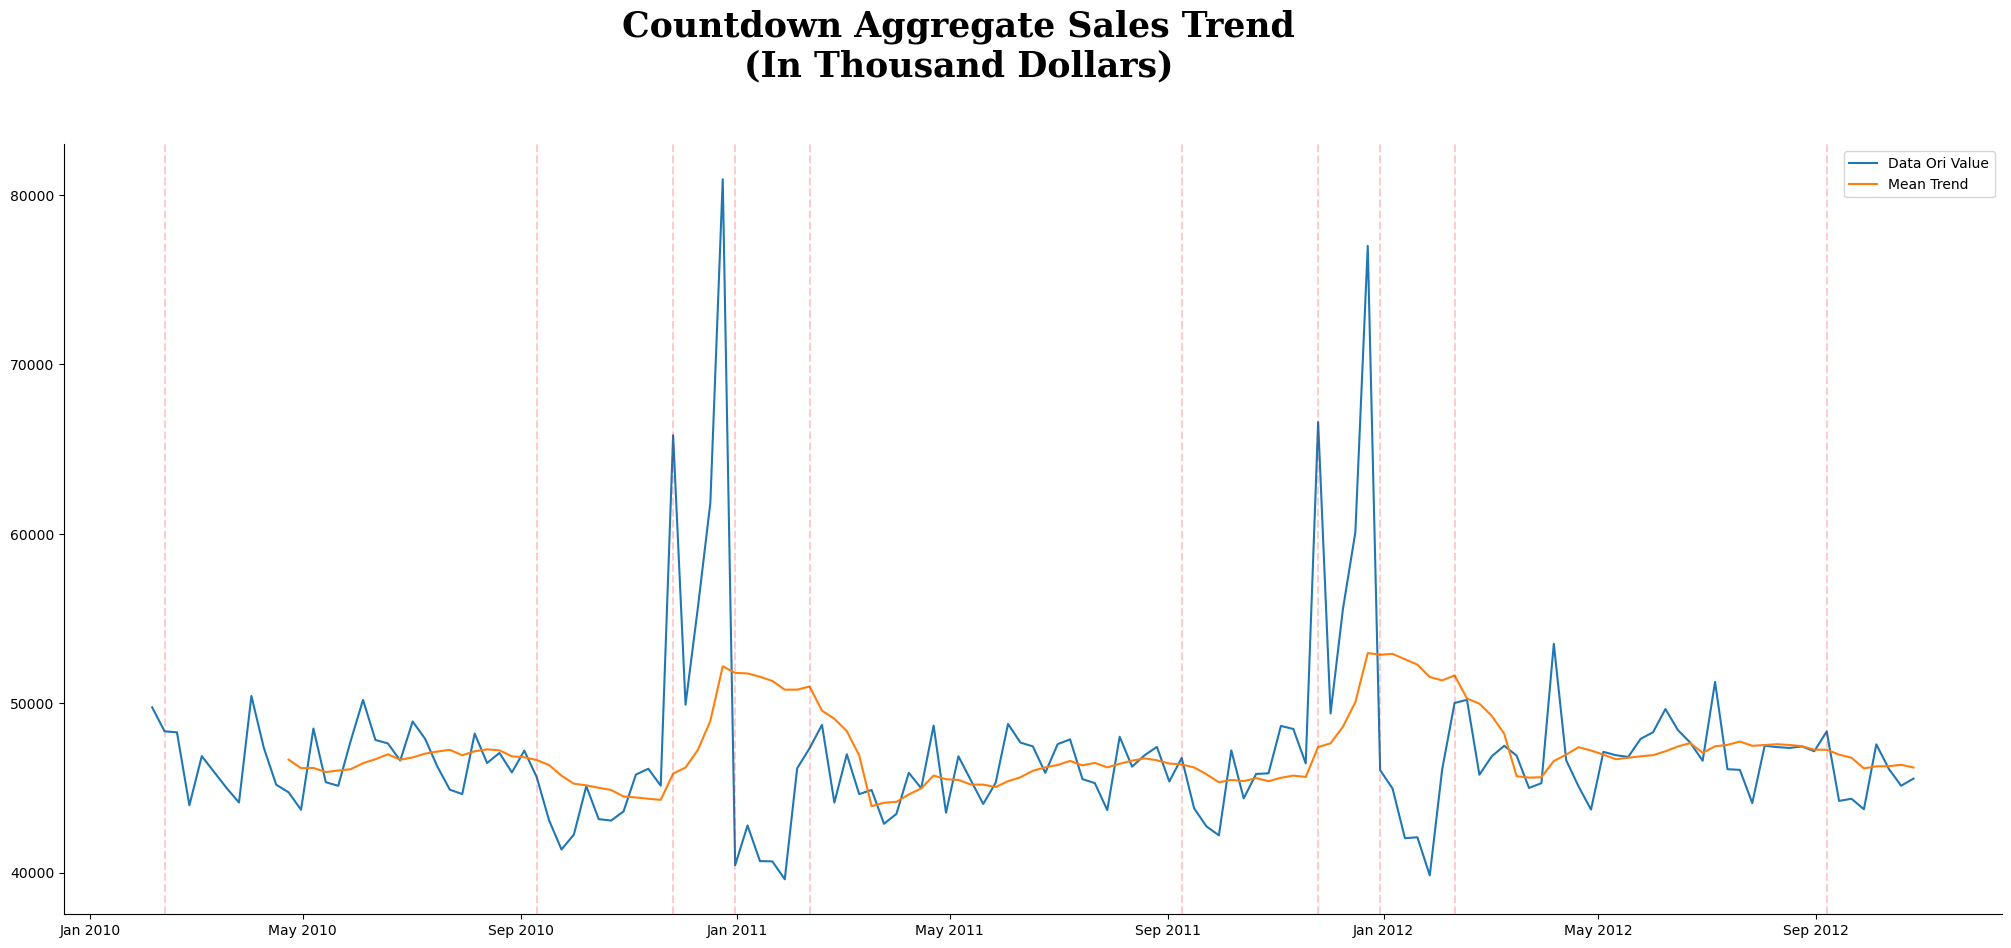

In [23]:
#Aggregate Sales for the whole Countdown Store
holiday_date = pd.to_datetime(['2010-02-12', '2010-09-10',
       '2010-11-26', '2010-12-31',
       '2011-02-11', '2011-09-09',
       '2011-11-25', '2011-12-30',
       '2012-02-10', '2012-09-07'])
locate = pd.to_datetime('2011-05-06')

agg_sales = panel.groupby('Date')['Weekly_Sales'].sum().reset_index()

fig, ax = plt.subplots(1, 1, figsize = (25, 10))
sns.lineplot(x = agg_sales['Date'], y = agg_sales['Weekly_Sales'], ax = ax, label = 'Data Ori Value')
sns.lineplot(x = agg_sales['Date'], y = agg_sales['Weekly_Sales'].rolling(12).mean(), ax = ax, 
             label = 'Mean Trend')

for i in holiday_date:
    ax.axvline(i, color = 'r', alpha = 0.2, ls='--')

for s in ['top', 'right']:
    ax.spines[s].set_visible(False)
    
ax.text(locate, 87000, 'Countdown Aggregate Sales Trend\n(In Thousand Dollars)', fontsize = 25, 
        fontweight = 'bold', fontfamily = 'serif', color = 'black', ha = 'center')
ax.set_ylabel('')
ax.set_xlabel('')
ax.xaxis.set_major_formatter(years_fmt)

plt.show()

##### Observations

Upon examining the graph, it becomes evident that the data contains a seasonal component that is heavily influenced by holiday dates (indicated by the red line). Countdown sales appear to surge during these holiday periods, while remaining stagnant during non-holiday dates. It is important to exercise caution when interpreting sales volume as a metric of success, as growth sales would provide a more accurate representation of Countdown's performance. In the following sections, we will delve deeper into which holidays contribute the most to Countdown's overall sales figures.


The data visualization presents a compelling case for the seasonal influence of holidays on Countdown's sales figures. Notably, there is a stark contrast between sales during holiday periods and non-holiday periods, with sales remaining relatively static during the latter. However, in order to gain a more nuanced understanding of Countdown's sales patterns, it is necessary to consider growth sales as a more accurate measure of success. Subsequently, we will conduct a detailed analysis to determine which holidays exert the greatest influence on overall sales performance

#### Which holiday have the highest sales?

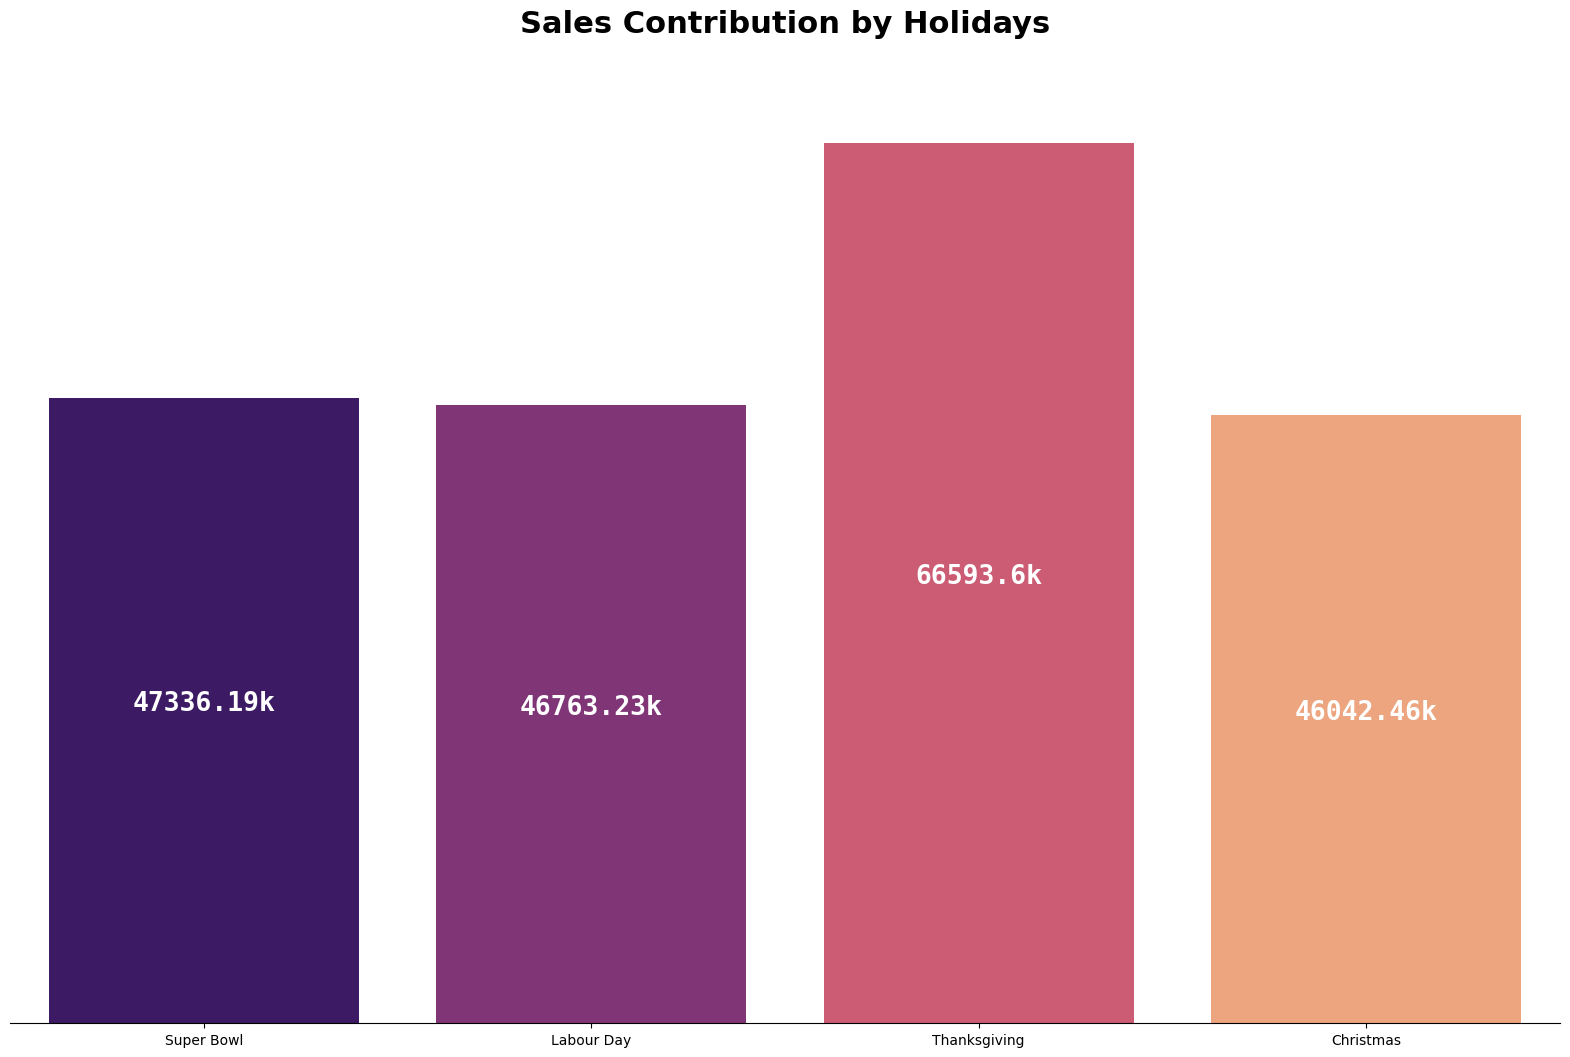

In [24]:
#Detail about sales in holiday, which holiday have highest sales?

#Defining specific holiday
super_bowl = ['2010-02-12', '2011-02-11', '2012-02-10']
labour_day = ['2010-09-10', '2011-09-09', '2012-09-07']
thanksgiving = ['2010-11-26', '2011-11-25', '2012-11-23']
christmas = ['2010-12-31', '2011-12-30', '2012-12-28']

super_bowl_sales = df[df['Date'] == '2011-02-11']['Weekly_Sales'].sum()
labour_day_sales = df[df['Date'] == '2011-09-09']['Weekly_Sales'].sum()
thanksgiving_sales = df[df['Date'] == '2011-11-25']['Weekly_Sales'].sum()
christmas_sales = df[df['Date'] == '2011-12-30']['Weekly_Sales'].sum()

data = {'Super Bowl': super_bowl_sales,'Labour Day': labour_day_sales, 
        'Thanksgiving': thanksgiving_sales,'Christmas': christmas_sales}

holiday_sales = round(pd.Series(data),2)

fig, ax = plt.subplots(1, 1, figsize=(20, 12))
sns.barplot(x = holiday_sales.index, y = holiday_sales, ax = ax, palette = 'magma')

for s in ['top', 'right', 'left']:
    ax.spines[s].set_visible(False)
ax.set_yticks([])
ax.set_ylabel('')
for ind, val in enumerate(holiday_sales):
    ax.text(x = ind, y = val/2, s = f'{str(val)}k', fontsize = 19, fontweight = 'bold', ha = 'center', 
            fontfamily = 'monospace', color = 'white')
ax.text(1.5, 75000, 'Sales Contribution by Holidays', fontsize = 22, fontweight = 'bold', 
            fontfamily = 'sans serif', color = 'black', ha = 'center')

plt.show()

In [25]:
pivot_table = pd.pivot_table(panel, values = ['Weekly_Sales', 'Temperature', 'Fuel_Price', 'CPI', 'Unemployment'], 
                             index = 'Date', aggfunc = {'Weekly_Sales': np.sum, 'Temperature': np.mean, 'Fuel_Price': np.mean,
                                                        'CPI': np.mean, 'Unemployment': np.mean}).reset_index()
pivot_table['Month'] = pivot_table['Date'].dt.month
pivot_table['Year'] = pivot_table['Date'].dt.year
pivot_table.head()

,Date,CPI,Fuel_Price,Temperature,Unemployment,Weekly_Sales,Month,Year
0,2010-02-05,167.729778,2.717844,34.037333,8.619311,49750.741,2,2010
1,2010-02-12,167.826889,2.694022,34.151333,8.619311,48336.676,2,2010
2,2010-02-19,167.873778,2.672067,37.719778,8.619311,48276.996,2,2010
3,2010-02-26,167.910444,2.683933,39.243556,8.619311,43968.572,2,2010
4,2010-03-05,167.949111,2.731200,42.917333,8.619311,46871.469,3,2010


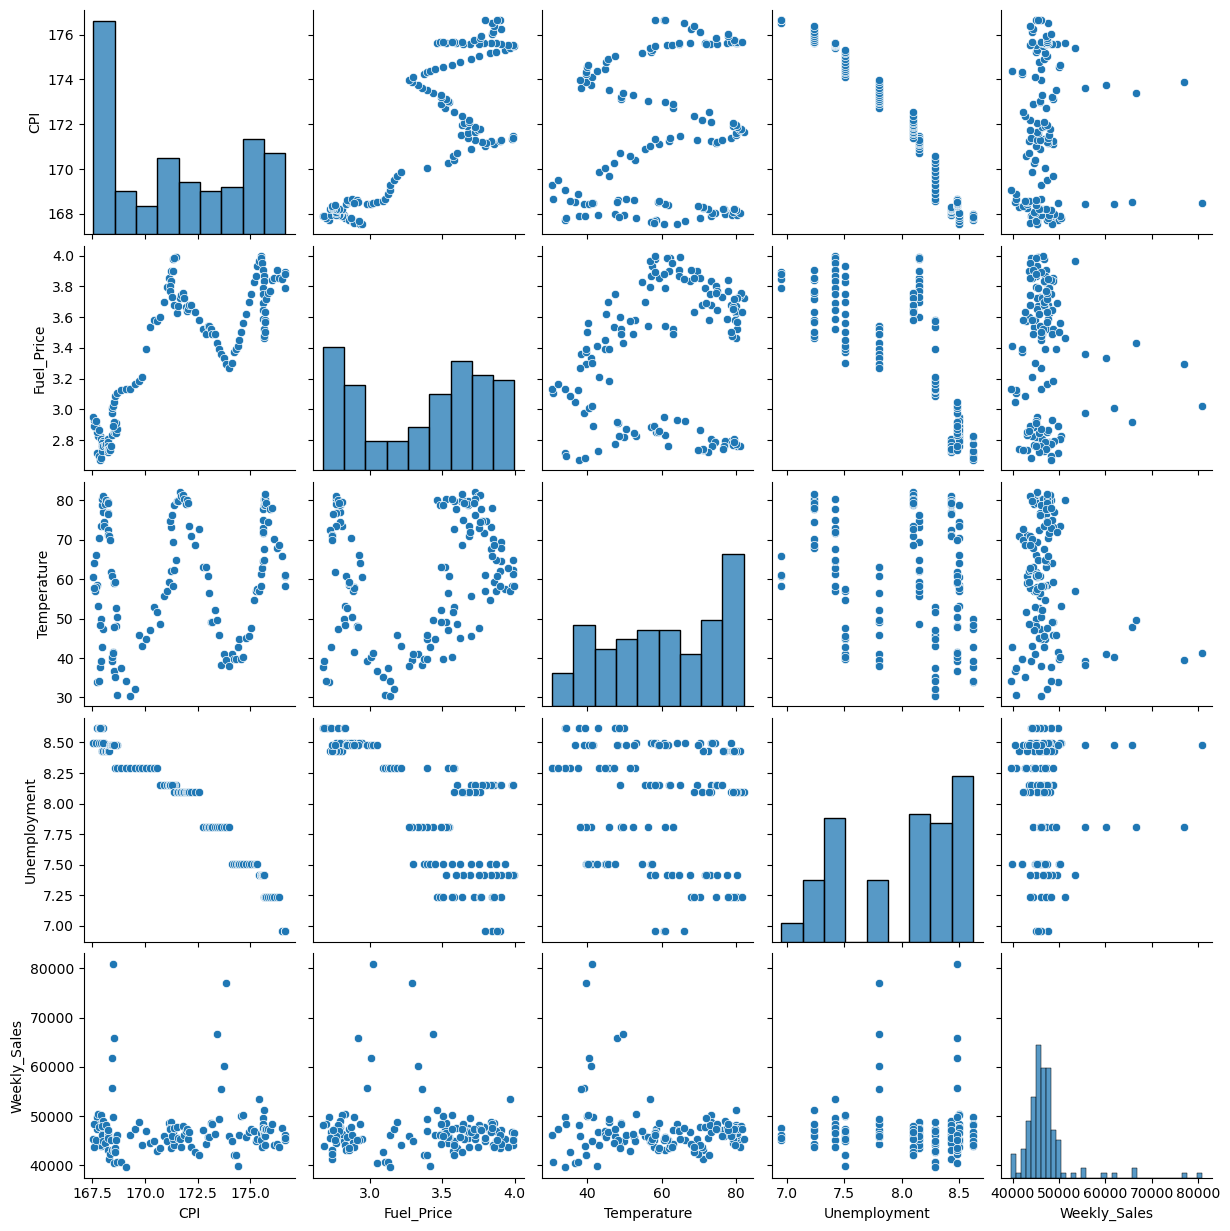

In [26]:
sns.pairplot(pivot_table.drop(['Month', 'Year'], axis = 1))

In [27]:
pivot_table.drop(['Month', 'Year'], axis = 1).corr()

,CPI,Fuel_Price,Temperature,Unemployment,Weekly_Sales
CPI,1.000000,0.824693,0.159415,-0.977429,0.023393
Fuel_Price,0.824693,1.000000,0.205757,-0.747205,-0.056722
Temperature,0.159415,0.205757,1.000000,-0.168460,-0.159160
Unemployment,-0.977429,-0.747205,-0.168460,1.000000,0.003524
Weekly_Sales,0.023393,-0.056722,-0.159160,0.003524,1.000000


Upon analysis, it appears that sales have a weak correlation with macroeconomic conditions. This could be attributed to the fact that we are utilizing weekly data, while macroeconomic variables such as CPI, unemployment, and fuel prices exhibit slow or rigid changes in the short term. As a result, any impact of these variables on sales may not be immediately evident, leading to a weaker correlation than anticipated.

The relationship between sales and macroeconomic conditions appears to be weaker than initially anticipated. This may be attributed to the fact that we are utilizing weekly data, while macroeconomic variables such as CPI, unemployment, and fuel prices experience slow or inflexible changes in the short term. Consequently, any effects of these variables on sales may not be immediately apparent, leading to a weaker correlation overall.

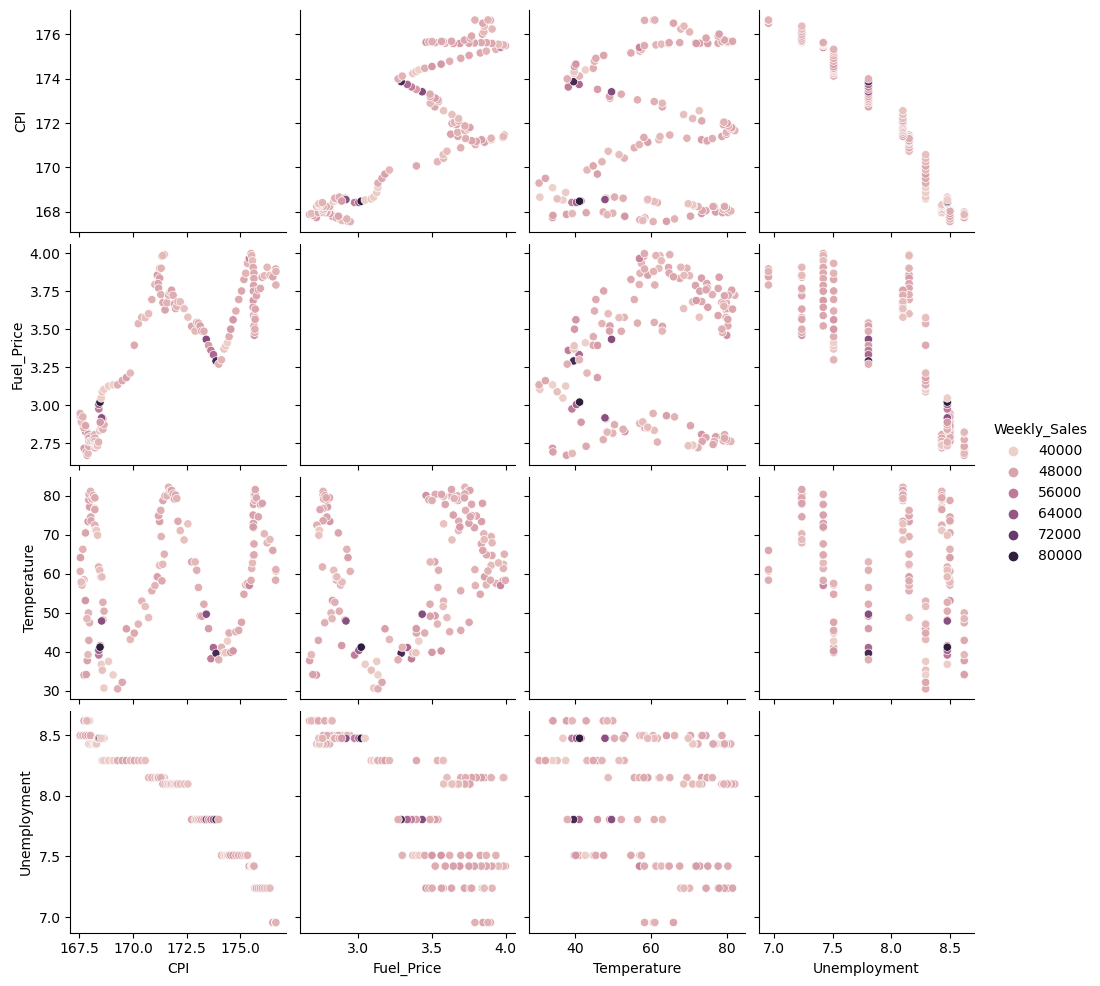

In [28]:
sns.pairplot(pivot_table.drop(['Month', 'Year'], axis = 1), hue='Weekly_Sales')

In [29]:
growth_df = panel[['Date', 'Weekly_Sales']].resample('M', on = 'Date').sum().reset_index()
growth_df['Rolling_Month'] = np.roll(growth_df['Weekly_Sales'], 1)
growth_df['Growth_MoM'] = round((growth_df['Weekly_Sales'] - growth_df['Rolling_Month']) / growth_df['Rolling_Month'] * 100, 2)
grotwh_df = growth_df.shift(-1)
growth_df['Year'] = growth_df['Date'].dt.year
growth_df['Month'] = growth_df['Date'].dt.month

super_bowl = ['2010-02-28', '2011-02-28', '2012-02-28']
labour_day = ['2010-09-30', '2011-09-30', '2012-09-30']
thanksgiving = ['2010-11-30', '2011-11-30', '2012-11-30']
christmas = ['2010-12-31', '2011-12-31', '2012-12-31']

g2010 = growth_df[growth_df['Year'] == 2010][['Month', 'Growth_MoM']].max()
g2011 = growth_df[growth_df['Year'] == 2011][['Month', 'Growth_MoM']].max()
g2012 = growth_df[growth_df['Year'] == 2012][['Month', 'Growth_MoM']].max()

Text(1.3, 0.1, '2012')

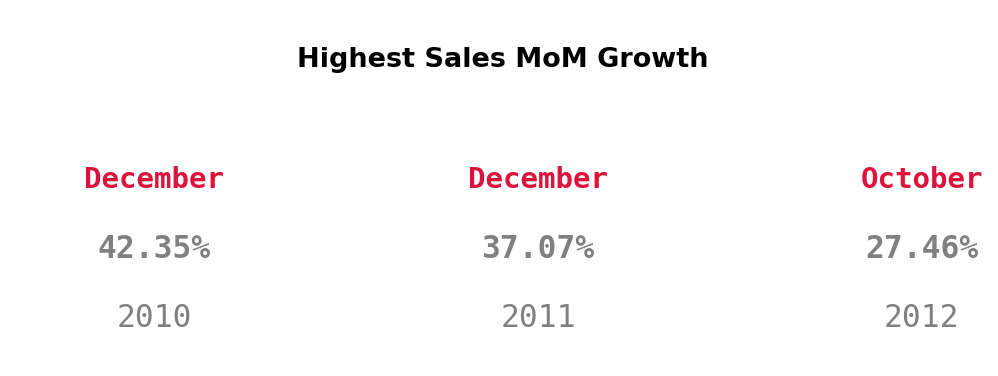

In [30]:
fig, ax = plt.subplots(1, 1, figsize = (6, 3), dpi = 150)

for s in ['top','right','left','bottom']:
    ax.spines[s].set_visible(False)
    
ax.set_yticklabels('')
ax.set_xticklabels('')
ax.tick_params(axis='both',length=0)

ax.text(0.7, 0.85, "Highest Sales MoM Growth" , color = 'black', fontsize = 13, fontweight = 'bold', 
         fontfamily = 'sanserif', ha = 'center')
ax.text(0.2, 0.5, "December", color = 'crimson', fontsize = 14, fontweight = 'bold', fontfamily = 'monospace', ha = 'center')
ax.text(0.2, 0.3, "42.35%", color = 'gray', fontsize = 15, fontfamily = 'monospace',ha = 'center', fontweight = 'bold')
ax.text(0.2, 0.1, "2010", color = 'gray',fontsize = 15, fontfamily = 'monospace', ha = 'center')
ax.text(0.75, 0.5, "December", color = 'crimson', fontsize = 14, fontweight = 'bold', fontfamily = 'monospace', ha = 'center')
ax.text(0.75, 0.3, "37.07%", color = 'gray', fontsize = 15, fontweight = 'bold', fontfamily = 'monospace', ha = 'center')
ax.text(0.75, 0.1, "2011", color = 'gray', fontsize = 15, fontfamily = 'monospace', ha = 'center')
ax.text(1.3, 0.5, "October", color = 'crimson', fontsize = 14, fontweight = 'bold', fontfamily = 'monospace', ha = 'center')
ax.text(1.3, 0.3, "27.46%", color = 'gray', fontsize = 15, fontfamily = 'monospace', ha = 'center', fontweight = 'bold')
ax.text(1.3, 0.1, "2012", color = 'gray', fontsize = 15, fontfamily = 'monospace', ha = 'center')

##### Observations

While Thanksgiving in November yields the highest sales figures amongst holidays, it is December that consistently sees the greatest growth in sales in the lead up to Christmas. Notably, in both 2010 and 2011, December registered the highest growth sales figures. However, it should be noted that in 2012, October saw the highest month-on-month (MoM) sales growth due to the absence of sales data for December of that year.


Our analysis reveals that December consistently exhibits the highest growth sales figures leading up to Christmas, despite Thanksgiving in November boasting the highest overall sales figures amongst holidays. Specifically, both 2010 and 2011 saw December record the greatest growth in sales. However, it is worth noting that in 2012, October saw the highest MoM sales growth as a result of the absence of sales data for December of that year.

#### Sales Panel Analysis by Store

Here we will see which of the Countdown Stores perform better when compared against another.

Text(7, 310000, 'Aggregate Sales by Store \n(In Thousand Dollars)')

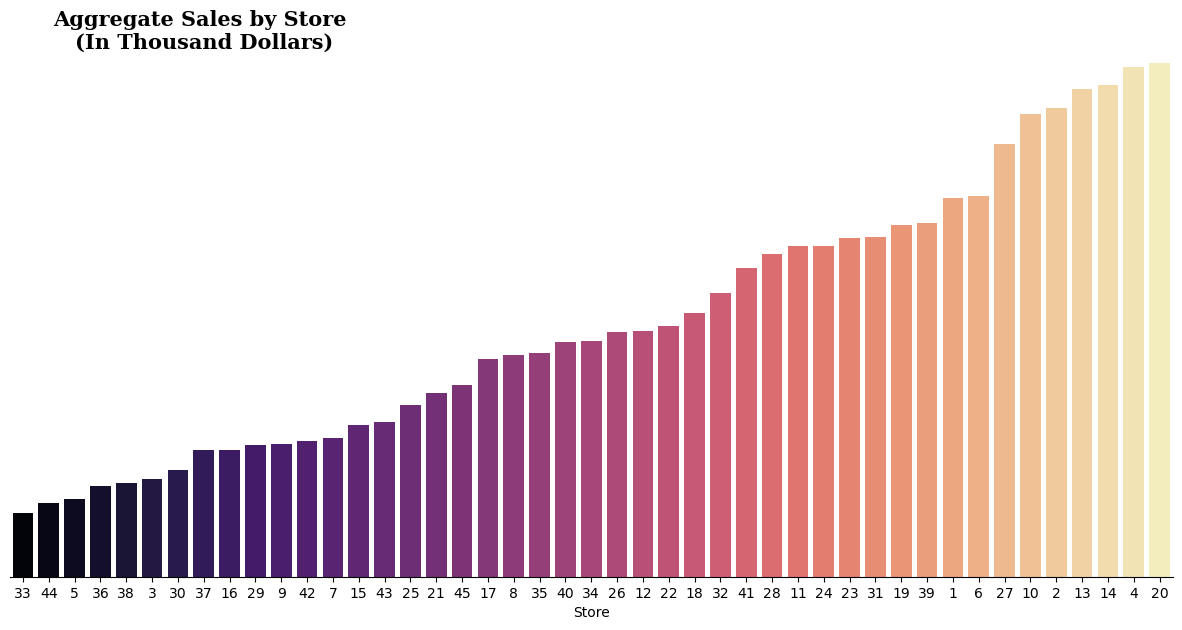

In [31]:
# Which store perform better?

sales_store = panel.groupby('Store')['Weekly_Sales'].sum().reset_index()

fig, ax = plt.subplots(1, 1, figsize = (15, 7))
sns.barplot(x='Store', y='Weekly_Sales', data=sales_store, order=sales_store.sort_values('Weekly_Sales').Store, ax = ax,
           palette = 'magma')

for s in ['top', 'right', 'left']:
    ax.spines[s].set_visible(False)
ax.set_yticks([])
ax.set_ylabel('')
ax.text(7, 310000, 'Aggregate Sales by Store \n(In Thousand Dollars)', fontsize = 15, fontweight = 'bold', 
        fontfamily = 'serif', color = 'black', ha = 'center')


Our analysis indicates that Store 20 boasts the highest sales figures during this period, followed closely by Stores 4 and 14. However, at this stage, we lack information about the exact location of these stores, and as such, our insights are limited. Nevertheless, we can delve deeper into the trends underpinning these sales figures to better understand their dynamics.

C:\Users\barar\AppData\Local\Temp\ipykernel_17364\2731719617.py:37: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  sns.lineplot(x =store14['Date'], y = store14['weekly_growth'], ax = ax[0], label = 'Store 14', palette = 'Set2')
C:\Users\barar\AppData\Local\Temp\ipykernel_17364\2731719617.py:38: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  sns.lineplot(x =store4['Date'], y = store4['weekly_growth'], ax = ax[0], label = 'Store 4', palette = 'Set2')
C:\Users\barar\AppData\Local\Temp\ipykernel_17364\2731719617.py:39: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  sns.lineplot(x =store20['Date'], y = store20['weekly_growth'], ax = ax[0], label = 'Store 20', palette = 'Set2')
C:\Users\barar\AppData\Local\Temp\ipykernel_17364\2731719617.py:42: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  sns.lineplot(x =store33['Date'], y = store33['weekly_growth'], ax = ax[1], l

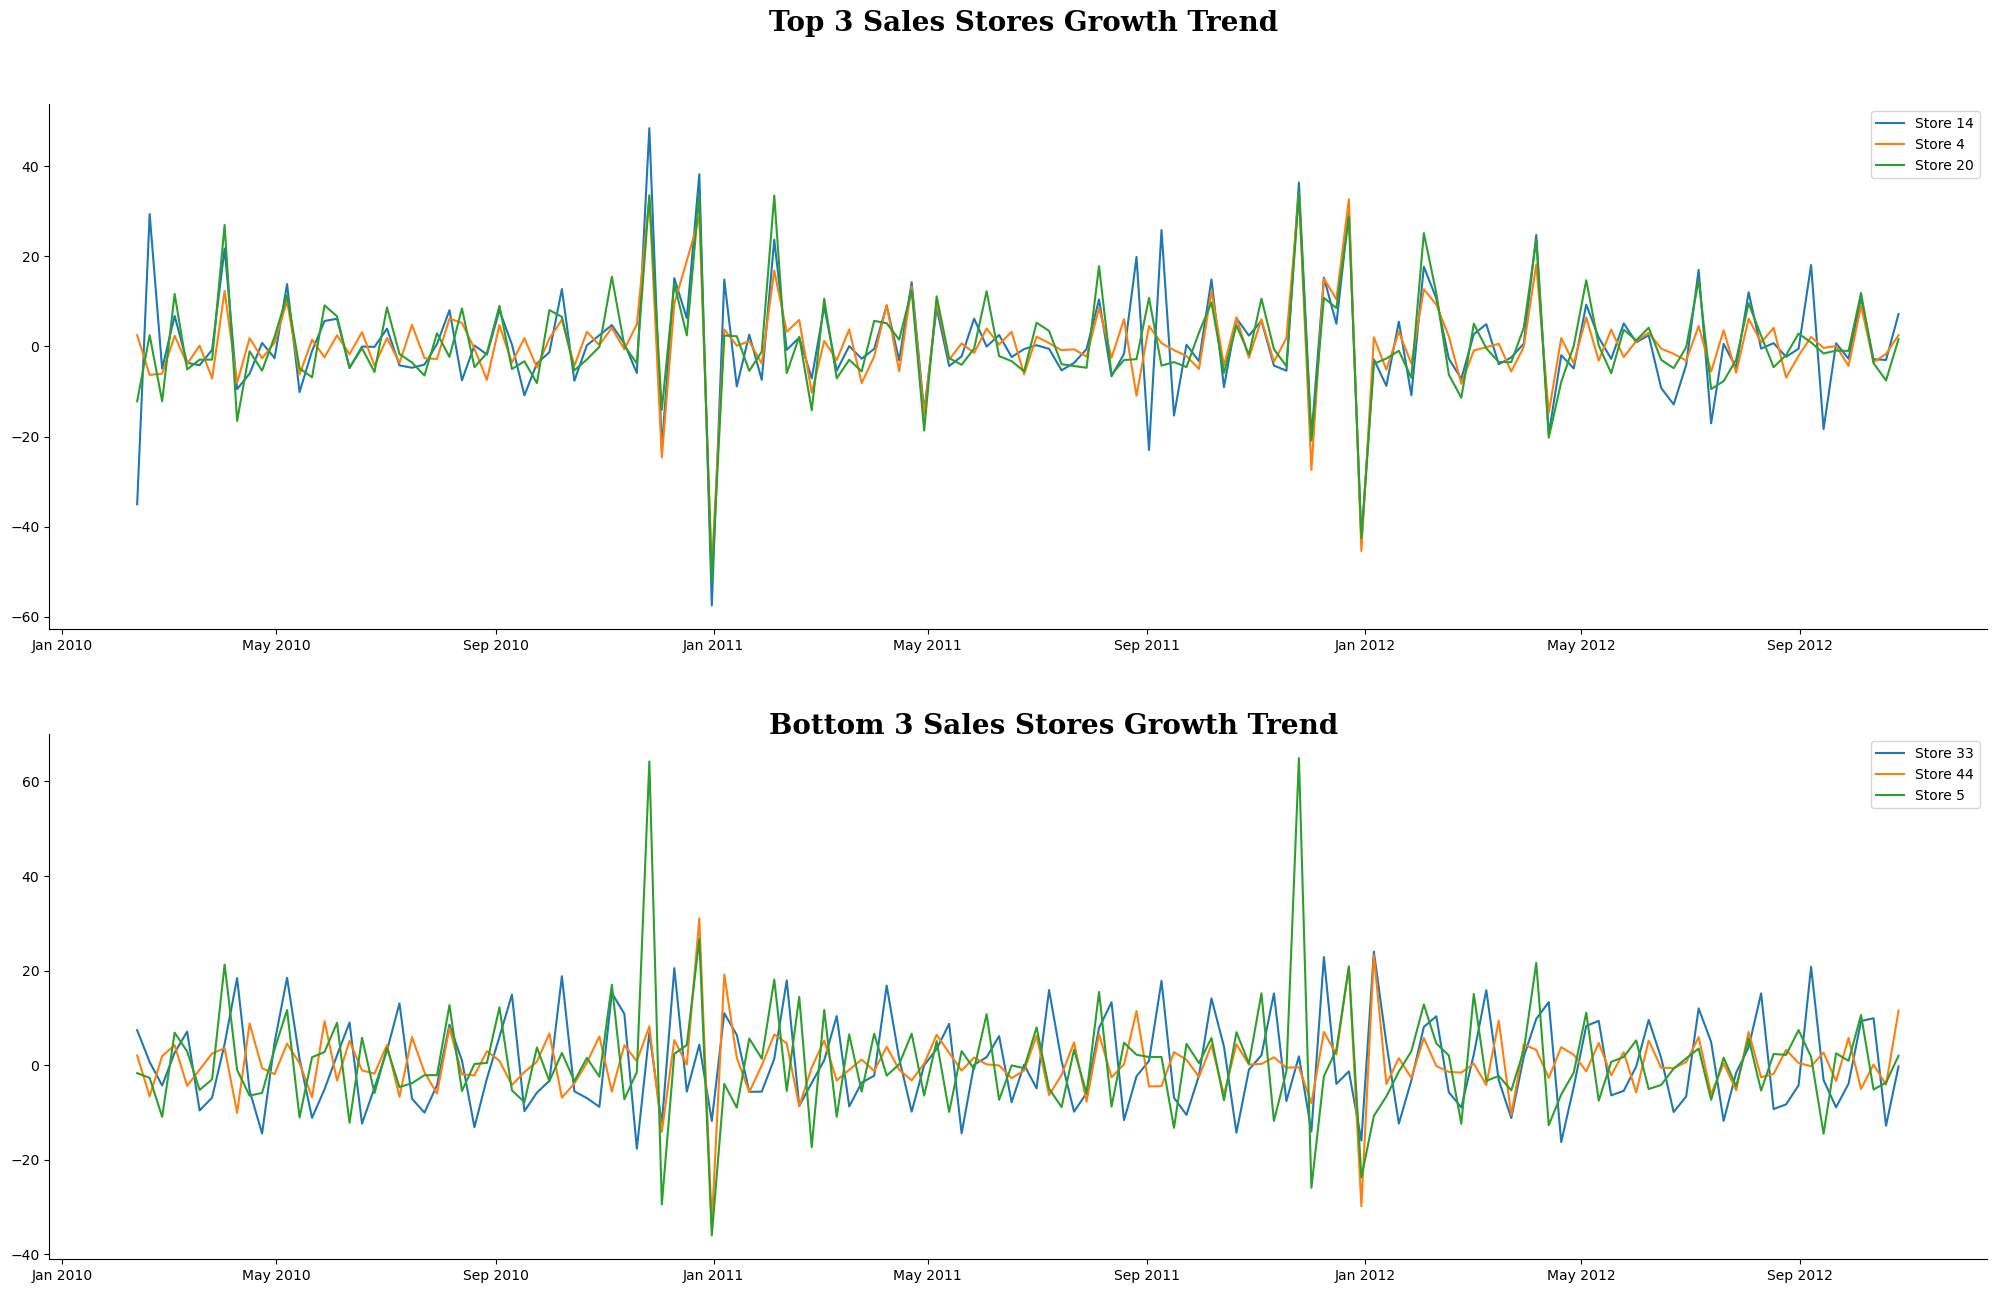

In [32]:
#Highest Store

locate1 = pd.to_datetime(['2011-02'])

store14 = panel[panel['Store'] == 14][['Date', 'Weekly_Sales']]
store14['roll'] = np.roll(store14['Weekly_Sales'], 1)
store14['weekly_growth'] = round((store14['Weekly_Sales'] - store14['roll']) / store14['roll'] * 100, 2)
store14 = store14.shift(-1)

store4 = panel[panel['Store'] == 4][['Date', 'Weekly_Sales']]
store4['roll'] = np.roll(store4['Weekly_Sales'], 1)
store4['weekly_growth'] = round((store4['Weekly_Sales'] - store4['roll']) / store4['roll'] * 100, 2)
store4 = store4.shift(-1)

store20 = panel[panel['Store'] == 20][['Date', 'Weekly_Sales']]
store20['roll'] = np.roll(store20['Weekly_Sales'], 1)
store20['weekly_growth'] = round((store20['Weekly_Sales'] - store20['roll']) / store20['roll'] * 100, 2)
store20 = store20.shift(-1)

#Lowest Store
store33 = panel[panel['Store'] == 33][['Date', 'Weekly_Sales']]
store33['roll'] = np.roll(store33['Weekly_Sales'], 1)
store33['weekly_growth'] = round((store33['Weekly_Sales'] - store33['roll']) / store33['roll'] * 100, 2)
store33 = store33.shift(-1)

store44 = panel[panel['Store'] == 44][['Date', 'Weekly_Sales']]
store44['roll'] = np.roll(store44['Weekly_Sales'], 1)
store44['weekly_growth'] = round((store44['Weekly_Sales'] - store44['roll']) / store44['roll'] * 100, 2)
store44 = store44.shift(-1)

store5 = panel[panel['Store'] == 5][['Date', 'Weekly_Sales']]
store5['roll'] = np.roll(store5['Weekly_Sales'], 1)
store5['weekly_growth'] = round((store5['Weekly_Sales'] - store5['roll']) / store5['roll'] * 100, 2)
store5 = store5.shift(-1)

fig, ax = plt.subplots(2, 1, figsize = (25, 15))
sns.lineplot(x =store14['Date'], y = store14['weekly_growth'], ax = ax[0], label = 'Store 14', palette = 'Set2')
sns.lineplot(x =store4['Date'], y = store4['weekly_growth'], ax = ax[0], label = 'Store 4', palette = 'Set2')
sns.lineplot(x =store20['Date'], y = store20['weekly_growth'], ax = ax[0], label = 'Store 20', palette = 'Set2')
#sns.lineplot(x = pivot_table['Date'], y = pivot_table['Temperature'], ax = ax[0], label = 'CPI')

sns.lineplot(x =store33['Date'], y = store33['weekly_growth'], ax = ax[1], label = 'Store 33', palette = 'Set2')
sns.lineplot(x =store44['Date'], y = store44['weekly_growth'], ax = ax[1], label = 'Store 44', palette = 'Set2')
sns.lineplot(x =store5['Date'], y = store5['weekly_growth'], ax = ax[1], label = 'Store 5', palette = 'Set2')

for s in ['top', 'right']:
    for i in [0,1]:
        ax[i].spines[s].set_visible(False)
        ax[i].set_ylabel('')
        ax[i].set_xlabel('')
        ax[i].xaxis.set_major_formatter(years_fmt)

ax[0].text(locate1, 70, 'Top 3 Sales Stores Growth Trend', color = 'black', fontsize = 20, fontweight = 'bold', 
         fontfamily = 'serif')
ax[1].text(locate1, 70, 'Bottom 3 Sales Stores Growth Trend', color = 'black', fontsize = 20, fontweight = 'bold', 
         fontfamily = 'serif')

plt.show()

##### Sales against Temperature Conditions

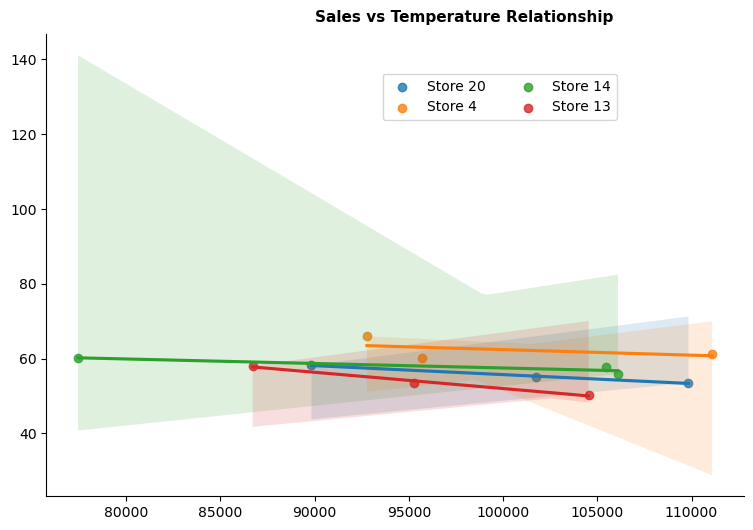

In [33]:
sales_store = sales_store.sort_values('Weekly_Sales', ascending = False)
store_list = list(sales_store['Store'][:4])

sales = panel.groupby(['Store', 'Year'])['Weekly_Sales'].sum()
temp = panel.groupby(['Store', 'Year'])['Temperature'].mean()
#cpi = pivot.groupby(['Store', 'Year'])['CPI'].mean()
#unem = pivot.groupby(['Store', 'Year'])['Unemployment'].mean()
#fp = pivot.groupby(['Store', 'Year'])['Fuel_Price'].mean()

fig, ax = plt.subplots(1, 1, figsize=(9, 6))

for sto in store_list:
    sns.regplot(x = sales[sto].values, y = temp[sto].values, label = sto)
    for s in ['top', 'right']:
        ax.spines[s].set_visible(False)
    
legend_labels, _ = ax.get_legend_handles_labels()
ax.legend(legend_labels, ['Store 20', 'Store 4', 'Store 14', 'Store 13'], ncol = 2, bbox_to_anchor = (0.65, 0.8), 
          loc = 'lower center')

ax.text(90000, 150, "Sales vs Temperature Relationship" , color = 'black', fontsize = 11, fontweight = 'bold', 
         fontfamily = 'sans serif')

plt.show()


Our analysis reveals that temperature exhibits the strongest correlation with sales amongst all features. However, the slopes - which represent the relative change in the dependent variable when the independent variable changes - are relatively small in the top four stores with the highest sales figures. To further clarify this relationship, we will turn to econometric methods. While software such as SPSS or Stata would be the ideal tools for this task, for the sake of simplicity we will employ the statmodels and linearregression libraries.

##### Weekly Sales against Macroeconomic Variables

Econometrics is a powerful tool employed by economists to understand the causal relationships between dependent (target) and independent (feature matrix) variables. There are three types of data that can be analyzed using econometric techniques: cross-section, time series, and pooled data (a combination of cross-section and time series).

**PooledOLS, Fixed-Effects (FE), and Random-Effects (RE)**

In panel data analysis, there are three main types of regression models: PooledOLS, Fixed-Effects (FE), and Random-Effects (RE). The PooledOLS model applies a simple OLS (Ordinary Least Squared) model to panel data, disregarding individual and time-specific characteristics and focusing solely on dependencies between individuals. On the other hand, the FE model determines individual effects of unobserved, independent variables as constant over time. Finally, the RE model determines individual effects of unobserved, independent variables as random variables over time, and can switch between OLS and FE models to focus on both the dependencies between and within individuals. In this analysis, we will employ all three methods to gain a comprehensive understanding of the data.

In [34]:
#building panel dataset format
panel_data = panel.set_index(['Store', 'Date'])
dates = panel_data.index.get_level_values('Date').to_list()
panel_data['Date'] = pd.Categorical(dates)
panel_data.drop(['Month', 'Year', 'Holiday_Flag'], axis = 1, inplace = True)
panel_data

CPI  Fuel_Price  Temperature  Unemployment  Weekly_Sales  \
Store Date                                                                      
1     2010-02-05  211.10       2.572        42.31         8.106      1643.691   
      2010-02-12  211.24       2.548        38.51         8.106      1641.957   
      2010-02-19  211.29       2.514        39.93         8.106      1611.968   
      2010-02-26  211.32       2.561        46.63         8.106      1409.728   
      2010-03-05  211.35       2.625        46.50         8.106      1554.807   
...                  ...         ...          ...           ...           ...   
45    2012-09-28  192.01       3.997        64.88         8.684       713.174   
      2012-10-05  192.17       3.985        64.89         8.667       733.455   
      2012-10-12  192.33       4.000        54.47         8.667       734.464   
      2012-10-19  192.33       3.969        56.47         8.667       718.126   
      2012-10-26  192.31       3.882        58.85         8.667       760.281   

                       Date  
Store Date                   
1     2010-02-05 2010-02-05  
      2010-02-12 2010-02-12  
      2010-02-19 2010-02-19  
      2010-02-26 2010-02-26  
      2010-03-05 2010-03-05  
...                     ...  
45    2012-09-28 2012-09-28  
      2012-10-05 2012-10-05  
      2012-10-12 2012-10-12  
      2012-10-19 2012-10-19  
      2012-10-26 2012-10-26  

[6435 rows x 6 columns]

In [35]:
#building dependent and independent variable
independent = sm.tools.tools.add_constant(panel_data[['Temperature', 'Fuel_Price', 'CPI', 'Unemployment']])
dependent = panel_data['Weekly_Sales']

#fitting variable into panel OLS method
model = PooledOLS(dependent, independent)
pooledOLS_res = model.fit(cov_type='clustered', cluster_entity=True)

residuals = pooledOLS_res.resids

In order to choose the appropriate regression method for our data, we first run it through the Pooled OLS regression. However, to make sure that this method is suitable for our data, we need to check if the three classical assumptions are met. Out of these assumptions, heteroskedasticity and autocorrelation can help us determine if PooledOLS is the right choice or if we need to switch to the Fixed Effect or Random Effect Model. If these assumptions cannot be met in PooledOLS, we may need to consider using a different regression method.

In [36]:
pooled_data = pd.concat([panel_data, residuals], axis = 1)
pooled_data = pooled_data.drop(['Date'], axis = 1).fillna(0)

#check regression assumption (heteroskedasticity)
breusch_pagan_test = list(het_breuschpagan(pooled_data['residual'], independent))
label_aut = ['LM-Stat', 'LM p-val', 'F-Stat', 'F p-val']
result_auto = pd.Series(breusch_pagan_test, index = label_aut)
print(result_auto)

LM-Stat     7.811835e+01
LM p-val    4.360310e-16
F-Stat      1.975422e+01
F p-val     3.537082e-16
dtype: float64


***Heteroskedasticity***

The significance level (alpha) is set at 0.05. Based on the p-value of 3.53, it indicates a violation of the heteroskedasticity assumption. If the p-value is less than alpha (0.05), we can conclude that there is no heteroskedasticity.

In [37]:
#check regression assumption (autocorrelation)
durbin_watson_test = durbin_watson(pooled_data['residual']) 
print(durbin_watson_test)

0.11257021240462842


The significance of autocorrelation is determined by comparing its p-value to a predetermined alpha value of 0.05. Since the p-value of 3.53 exceeds 0.05, we can conclude that there is a violation of autocorrelation.

Moving on to the next step, we will use both Fixed Effect and Random Effect methods, and decide which one to choose as the robust model by conducting a statistical **Hausman test**. If the p-value is less than 0.05, then Fixed Effect would be the preferred model.

In [38]:
#Fixed Effect
model_fe = PanelOLS(dependent, independent, entity_effects = True) 
fe_reg = model_fe.fit() 

#Random Effect
model_re = RandomEffects(dependent, independent)
re_reg = model_re.fit()

In [39]:
def hausman(fe, re):
    b = fe.params
    B = re.params
    v_b = fe.cov
    v_B = re.cov
    df = b[np.abs(b) < 1e8].size
    chi2 = np.dot((b - B).T, np.linalg.inv(v_b - v_B).dot(b - B)) 
    pval = stats.chi2.sf(chi2, df)
    return chi2, df, pval

hausman_results = hausman(fe_reg, re_reg)
print('p-Value: ' + str(hausman_results[2]))

p-Value: 0.536153985538639


In [40]:
#Use Random Effect for interpretation purpose.

print(re_reg)

                        RandomEffects Estimation Summary                        
Dep. Variable:           Weekly_Sales   R-squared:                        0.0204
Estimator:              RandomEffects   R-squared (Between):             -0.0584
No. Observations:                6435   R-squared (Within):               0.0209
Date:                Tue, Apr 04 2023   R-squared (Overall):             -0.0519
Time:                        12:25:09   Log-likelihood                -4.183e+04
Cov. Estimator:            Unadjusted                                           
                                        F-statistic:                      33.542
Entities:                          45   P-value                           0.0000
Avg Obs:                       143.00   Distribution:                  F(4,6430)
Min Obs:                       143.00                                           
Max Obs:                       143.00   F-statistic (robust):             33.542
                            

It is commonly accepted that an independent variable has a considerable influence on the dependent variable when the p-value is below 0.05.

Upon conducting analysis, it is evident that all independent variables, namely Temperature, CPI, Fuel Price, and Unemployment, have significant correlations with Weekly Sales. Despite this significance, the slopes or coefficients, as well as the R2 value, are relatively small.

As an instance, Temperature has a coefficient of -1.0308, implying that an increase in temperature by 1 degree could reduce sales by 1k dollars.

### Conclusion

It is important for the management to consider the seasonal component in sales when making decisions about stocking, merchandising, and marketing. While Thanksgiving holiday in November generally generates more sales than other holidays, the period leading up to Christmas in December has seen higher month-on-month sales growth. Store 20 has consistently reported high sales volume over the past three years, but its growth has been largely driven by holiday dates.

Through the use of econometrics and panel regression methods, we have determined that macroeconomic conditions have a significant impact on weekly sales, despite the small slope and R2 values. This indicates that external factors outside of the model, such as customer buying behavior, social factors, technology, and other issues, may greatly affect Countdown sales.